In [31]:
import os
import glob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import torch
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import matplotlib.pyplot as plt

ham_folder = 'data/enron1/ham/'
spam_folder = 'data/enron1/spam/'

# 读取ham和spam文件夹中的所有文件
ham_files = glob.glob(os.path.join(ham_folder, '*.txt'))
spam_files = glob.glob(os.path.join(spam_folder, '*.txt'))

# 读取文件内容
def read_files(file_list):
    data = []
    for file_path in file_list:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            data.append(file.read())
    return data

ham_data = read_files(ham_files)
spam_data = read_files(spam_files)

# 查看数据的一部分
print(ham_data[0])  # 打印第一封ham邮件的内容
print(spam_data[0])  # 打印第一封spam邮件的内容

ham_data = read_files(ham_files)
spam_data = read_files(spam_files)

Subject: christmas tree farm pictures

Subject: dobmeos with hgh my energy level has gone up ! stukm
introducing
doctor - formulated
hgh
human growth hormone - also called hgh
is referred to in medical science as the master hormone . it is very plentiful
when we are young , but near the age of twenty - one our bodies begin to produce
less of it . by the time we are forty nearly everyone is deficient in hgh ,
and at eighty our production has normally diminished at least 90 - 95 % .
advantages of hgh :
- increased muscle strength
- loss in body fat
- increased bone density
- lower blood pressure
- quickens wound healing
- reduces cellulite
- improved vision
- wrinkle disappearance
- increased skin thickness texture
- increased energy levels
- improved sleep and emotional stability
- improved memory and mental alertness
- increased sexual potency
- resistance to common illness
- strengthened heart muscle
- controlled cholesterol
- controlled mood swings
- new hair growth and color restore

In [54]:
# 合并ham和spam数据，并创建标签
emails = ham_data + spam_data
labels = [0] * len(ham_data) + [1] * len(spam_data)  # 0: ham, 1: spam

# 使用CountVectorizer转换为词袋模型
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(emails).toarray()
y = np.array(labels)

# 将数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")

训练集样本数: 4137, 测试集样本数: 1035


Step 0/1000 | Loss: 16498.9043
Step 100/1000 | Loss: 4618.4213
Step 200/1000 | Loss: 2081.6429
Step 300/1000 | Loss: 1459.7635
Step 400/1000 | Loss: 1333.8931
Step 500/1000 | Loss: 1161.3910
Step 600/1000 | Loss: 948.1375
Step 700/1000 | Loss: 918.7519
Step 800/1000 | Loss: 836.0745
Step 900/1000 | Loss: 807.2764


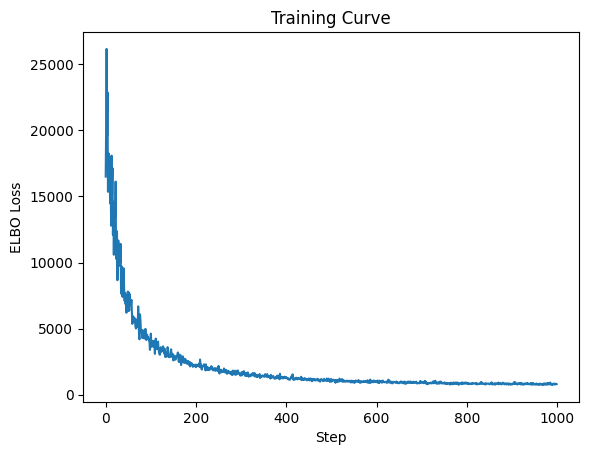

In [74]:
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
import torch

# 转换数据为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)

# 定义变分贝叶斯分类模型
def model(X_data, y_data):
    # 先验：每个特征有一个均值为0、方差为1的高斯分布
    with pyro.plate('features', X_data.shape[1]):  # 每个特征共享w
        w = pyro.sample('w', dist.Normal(torch.zeros(X_data.shape[1]), torch.ones(X_data.shape[1])))
    
    b = pyro.sample('b', dist.Normal(0., 1.))
    
    # 线性模型
    linear_model = torch.matmul(X_data, w) + b
    logits = torch.sigmoid(linear_model)
    
    # 观测：伯努利分布
    with pyro.plate('data', X_data.shape[0]):  # 每个数据点独立观测
        pyro.sample('obs', dist.Bernoulli(logits), obs=y_data)

# 定义变分推断的变分分布
def guide(X_data, y_data):
    # 使用变分分布对w和b进行推断
    w_loc = pyro.param('w_loc', torch.randn(X_data.shape[1]))
    w_scale = pyro.param('w_scale', torch.ones(X_data.shape[1]), constraint=torch.distributions.constraints.positive)
    b_loc = pyro.param('b_loc', torch.tensor(0.))
    b_scale = pyro.param('b_scale', torch.tensor(1.), constraint=torch.distributions.constraints.positive)
    
    with pyro.plate('features', X_data.shape[1]):
        pyro.sample('w', dist.Normal(w_loc, w_scale))
    
    pyro.sample('b', dist.Normal(b_loc, b_scale))

# 设置Pyro优化器
optimizer = pyro.optim.Adam({'lr': 0.01})
pyro.clear_param_store()

# 进行变分推断
svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())
num_steps = 1000
losses = []

for step in range(num_steps):
    loss = svi.step(X_train_tensor, y_train_tensor)
    losses.append(loss)
    if step % 100 == 0:  
        print(f"Step {step}/{num_steps} | Loss: {loss:.4f}")

# 绘制训练曲线
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('ELBO Loss')
plt.title('Training Curve')
plt.show()

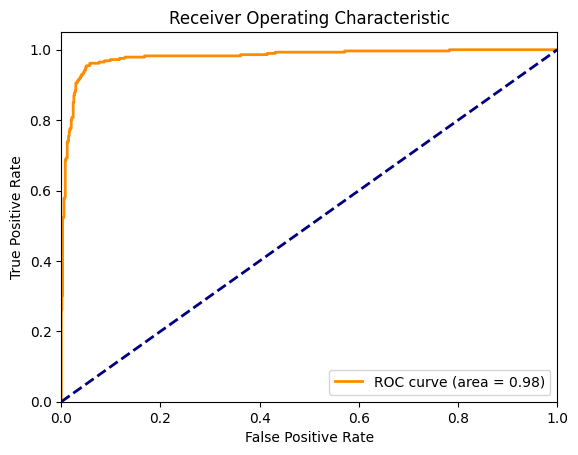

In [75]:
from sklearn.metrics import roc_curve, auc

# 获取模型的预测概率
w_loc = pyro.param('w_loc')
w_scale = pyro.param('w_scale')
b_loc = pyro.param('b_loc')
b_scale = pyro.param('b_scale')

w = torch.normal(w_loc, w_scale)
b = torch.normal(b_loc, b_scale)

logits_test = torch.matmul(torch.tensor(X_test, dtype=torch.float), w) + b
probs = torch.sigmoid(logits_test)

# 计算 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, probs.detach().numpy())
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [76]:
from sklearn.metrics import classification_report

# 获取最终的分类结果
predictions = (probs > 0.5).long()

# 打印分类报告
print(classification_report(y_test, predictions.numpy()))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       749
           1       0.90      0.92      0.91       286

    accuracy                           0.95      1035
   macro avg       0.94      0.94      0.94      1035
weighted avg       0.95      0.95      0.95      1035



## 进一步讨论

### 使用tfidf代替词频特征

TF-IDF feature matrix shape: (4137, 5000)
Step 0/1000 | Loss: 5481.5449
Step 100/1000 | Loss: 2327.7370
Step 200/1000 | Loss: 1507.6769
Step 300/1000 | Loss: 1249.2207
Step 400/1000 | Loss: 1108.8697
Step 500/1000 | Loss: 1101.0622
Step 600/1000 | Loss: 1070.5813
Step 700/1000 | Loss: 1058.3048
Step 800/1000 | Loss: 1026.6535
Step 900/1000 | Loss: 1048.0955


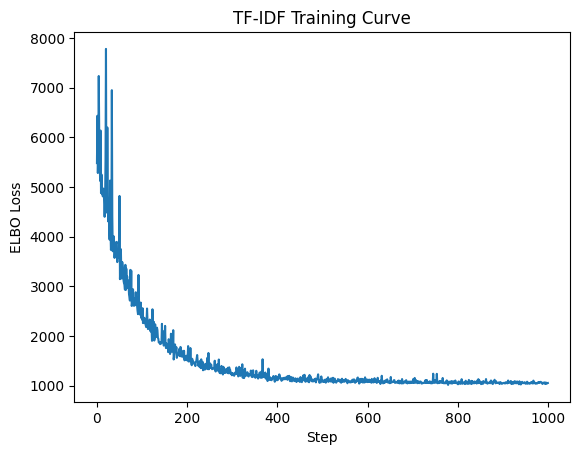

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer  # 导入TfidfVectorizer

# 使用TfidfVectorizer代替CountVectorizer
vectorizer = TfidfVectorizer(stop_words='english',max_features=5000)  # 忽略常见的停用词

# 生成TF-IDF特征矩阵
X = vectorizer.fit_transform(emails)
y = labels

# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 打印一下TF-IDF矩阵的形状，确保特征维度正常
print(f"TF-IDF feature matrix shape: {X_train.shape}")

# 将稀疏矩阵转换为稠密矩阵
X_train = X_train.toarray()  # 转换为稠密矩阵
X_test = X_test.toarray()

# 转换数据为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)


optimizer = pyro.optim.Adam({'lr': 0.01})

pyro.clear_param_store()

svi = pyro.infer.SVI(model, guide, optimizer, loss=pyro.infer.Trace_ELBO())
num_steps = 1000
losses = []

for step in range(num_steps):
    loss = svi.step(X_train_tensor, y_train_tensor)
    losses.append(loss)
    if step % 100 == 0:  
        print(f"Step {step}/{num_steps} | Loss: {loss:.4f}")

# 绘制训练曲线
plt.plot(losses)
plt.xlabel('Step')
plt.ylabel('ELBO Loss')
plt.title('TF-IDF Training Curve')
plt.show()

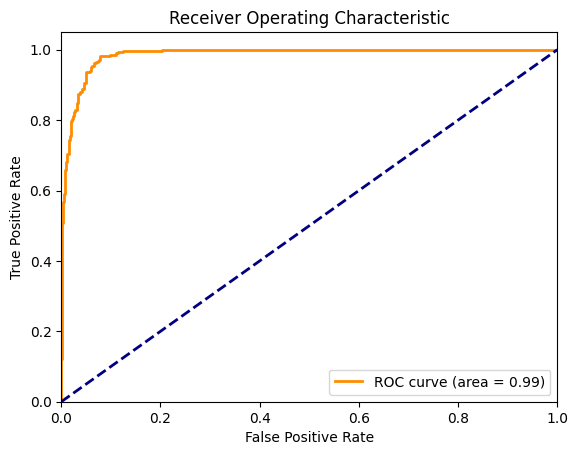

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       749
           1       0.88      0.90      0.89       286

    accuracy                           0.94      1035
   macro avg       0.92      0.92      0.92      1035
weighted avg       0.94      0.94      0.94      1035



In [70]:
from sklearn.metrics import roc_curve, auc

# 获取模型的预测概率
w_loc = pyro.param('w_loc')
w_scale = pyro.param('w_scale')
b_loc = pyro.param('b_loc')
b_scale = pyro.param('b_scale')

w = torch.normal(w_loc, w_scale)
b = torch.normal(b_loc, b_scale)

logits_test = torch.matmul(torch.tensor(X_test, dtype=torch.float), w) + b
probs = torch.sigmoid(logits_test)

# 计算 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, probs.detach().numpy())
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

from sklearn.metrics import classification_report

# 获取最终的分类结果
predictions = (probs > 0.5).long()

# 打印分类报告
print(classification_report(y_test, predictions.numpy()))

### 朴素贝叶斯

训练集样本数: 4137, 测试集样本数: 1035


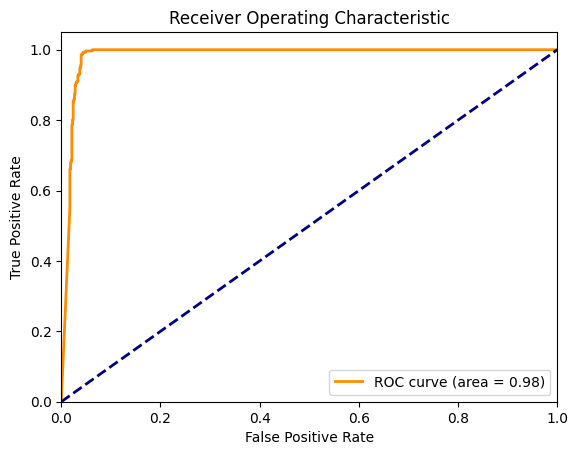

准确率: 95.85%
分类报告:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       749
           1       0.90      0.95      0.93       286

    accuracy                           0.96      1035
   macro avg       0.94      0.96      0.95      1035
weighted avg       0.96      0.96      0.96      1035



In [72]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score

# 合并ham和spam数据，并创建标签
emails = ham_data + spam_data
labels = [0] * len(ham_data) + [1] * len(spam_data)  # 0: ham, 1: spam

# 使用CountVectorizer转换为词袋模型
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(emails).toarray()
y = np.array(labels)

# 将数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"训练集样本数: {X_train.shape[0]}, 测试集样本数: {X_test.shape[0]}")

# 初始化朴素贝叶斯分类器
nb_classifier = MultinomialNB()

# 使用训练集训练模型
nb_classifier.fit(X_train, y_train)

# 使用测试集进行预测
y_pred = nb_classifier.predict(X_test)


import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# 你的数据处理部分
emails = ham_data + spam_data
labels = [0] * len(ham_data) + [1] * len(spam_data)  # 0: ham, 1: spam

# 使用 CountVectorizer 转换为词袋模型
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(emails).toarray()
y = np.array(labels)

# 将数据分割为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化并训练朴素贝叶斯分类器
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

# 获取预测的概率值
y_prob = nb_classifier.predict_proba(X_test)[:, 1]  # 获取属于类别 1 (spam) 的概率

# 计算 ROC 曲线
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 输出准确率和分类报告
accuracy = accuracy_score(y_test, y_pred)
print(f"准确率: {accuracy * 100:.2f}%")
print("分类报告:")
print(classification_report(y_test, y_pred))